# Anomaly Detection

The objective of this notebook is to create a reconstruction autoencoder AI model to detect ssh login intrusion.

In [298]:
import pandas as pd
import tensorflow as tf
import numpy as np
import seaborn as sns

from keras.models import Model, Sequential
from keras.layers import Dense
from keras import Input, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt

sns.set(font_scale=1.4)
sns.set_style("white")
sns.set_style("ticks")

The following data is extracted from the syslog of a Linux VM on Azure. "myazure1" is a valid user that has successfully logged into the VM several times. Other users are unsuccessfully tried by the bots on the internet. Although the data is labelled, the labels are used only to validate the efficacy of the model.

The definition of the data attributes are given below
- **login_success** - Whether the SSH login is successful (1) or not (0)
- **wrong_password** - Whether the SSH password was wrong (1) or correct (0)
- **invalid_user** - Whether the SSH user is invalid (1) or valid (0)
- **last_login_success** - Whether the given user's last login was successful (1) or not (0)
- **last_ip_login_failure** - Whether the source IP and user combination failed to login last time (1) or not (0)
- **anomaly** - Whether there  is anomaly (1) or not (0). All the users tried by the bots on the internet are marked as anomaly

In [299]:
PATH_TO_DATA = 'https://raw.githubusercontent.com/saptarshibasu/anomaly-detection/main/sample-data/sshlogin_3.csv'

data = pd.read_csv(PATH_TO_DATA, header = 0)

data.head(100)

,login_success,wrong_password,invalid_user,last_login_success,last_ip_login_failure,user,source_ip,source_port,anomaly
0,0,0,1,0,0,profile1,102.22.177.9,50290,1
1,0,0,1,0,1,profile1,102.22.177.9,56554,1
2,0,0,1,0,1,profile1,102.22.177.9,51287,1
3,0,0,1,0,1,profile1,102.22.177.9,65310,1
4,0,0,1,0,0,user1,102.22.177.9,65164,1
...,...,...,...,...,...,...,...,...,...
95,0,0,1,0,1,administrator,102.22.177.9,54649,1
96,0,0,1,0,1,administrator,102.22.177.9,58209,1
97,0,0,1,0,1,administrator,102.22.177.9,59447,1
98,0,0,1,0,1,administrator,102.22.177.9,61853,1


In [300]:
TARGET = 'anomaly'
USER = 'user'
SOURCE_IP = 'source_ip'
SOURCE_PORT = 'source_port'

features = data.drop([TARGET, USER, SOURCE_IP, SOURCE_PORT], axis=1) / 2
target = data[TARGET]

x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, stratify=target
)

train_index = y_train[y_train == 0].index
train_data = x_train.loc[train_index]
target_data = y_train.loc[train_index]

features.head()

,login_success,wrong_password,invalid_user,last_login_success,last_ip_login_failure
0,0.0,0.0,0.5,0.0,0.0
1,0.0,0.0,0.5,0.0,0.5
2,0.0,0.0,0.5,0.0,0.5
3,0.0,0.0,0.5,0.0,0.5
4,0.0,0.0,0.5,0.0,0.0


In [301]:
model = Sequential(
[
    Input(shape = (train_data.shape[1],)),
    Dense(5, activation=tf.nn.relu),
    Dense(3, activation=tf.nn.relu),
    Dense(5, activation=tf.nn.sigmoid)
])

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

history = model.fit(train_data, train_data, 
          epochs=500,
          batch_size=200,
          shuffle=True,
          validation_split=0.3,
          callbacks=[
              callbacks.EarlyStopping(monitor="val_loss", patience=5)
          ],
        )


Epoch 1/500
1/1 [==============================] - 2s 2s/step - loss: 0.1519 - val_loss: 0.1517
Epoch 2/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1516 - val_loss: 0.1515
Epoch 3/500
1/1 [==============================] - 0s 61ms/step - loss: 0.1514 - val_loss: 0.1513
Epoch 4/500
1/1 [==============================] - 0s 55ms/step - loss: 0.1512 - val_loss: 0.1511
Epoch 5/500
1/1 [==============================] - 0s 59ms/step - loss: 0.1510 - val_loss: 0.1509
Epoch 6/500
1/1 [==============================] - 0s 60ms/step - loss: 0.1508 - val_loss: 0.1507
Epoch 7/500
1/1 [==============================] - 0s 62ms/step - loss: 0.1506 - val_loss: 0.1505
Epoch 8/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1504 - val_loss: 0.1503
Epoch 9/500
1/1 [==============================] - 0s 58ms/step - loss: 0.1502 - val_loss: 0.1501
Epoch 10/500
1/1 [==============================] - 0s 51ms/step - loss: 0.1500 - val_loss: 0.1499
Epoch 11/500
1/1 [===

Epoch 82/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1374 - val_loss: 0.1372
Epoch 83/500
1/1 [==============================] - 0s 53ms/step - loss: 0.1372 - val_loss: 0.1371
Epoch 84/500
1/1 [==============================] - 0s 53ms/step - loss: 0.1370 - val_loss: 0.1369
Epoch 85/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1368 - val_loss: 0.1367
Epoch 86/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1366 - val_loss: 0.1365
Epoch 87/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1364 - val_loss: 0.1363
Epoch 88/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1362 - val_loss: 0.1361
Epoch 89/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1360 - val_loss: 0.1359
Epoch 90/500
1/1 [==============================] - 0s 56ms/step - loss: 0.1358 - val_loss: 0.1357
Epoch 91/500
1/1 [==============================] - 0s 77ms/step - loss: 0.1356 - val_loss: 0.1355
Epoch 92/5

Epoch 164/500
1/1 [==============================] - 0s 45ms/step - loss: 0.1136 - val_loss: 0.1132
Epoch 165/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1132 - val_loss: 0.1127
Epoch 166/500
1/1 [==============================] - 0s 99ms/step - loss: 0.1127 - val_loss: 0.1123
Epoch 167/500
1/1 [==============================] - 0s 50ms/step - loss: 0.1123 - val_loss: 0.1119
Epoch 168/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1119 - val_loss: 0.1114
Epoch 169/500
1/1 [==============================] - 0s 47ms/step - loss: 0.1114 - val_loss: 0.1110
Epoch 170/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1110 - val_loss: 0.1105
Epoch 171/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1105 - val_loss: 0.1100
Epoch 172/500
1/1 [==============================] - 0s 49ms/step - loss: 0.1101 - val_loss: 0.1096
Epoch 173/500
1/1 [==============================] - 0s 48ms/step - loss: 0.1096 - val_loss: 0.1091


Epoch 246/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0712 - val_loss: 0.0705
Epoch 247/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0707 - val_loss: 0.0700
Epoch 248/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0702 - val_loss: 0.0695
Epoch 249/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0697 - val_loss: 0.0690
Epoch 250/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0692 - val_loss: 0.0685
Epoch 251/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0687 - val_loss: 0.0680
Epoch 252/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0682 - val_loss: 0.0675
Epoch 253/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0677 - val_loss: 0.0670
Epoch 254/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0672 - val_loss: 0.0665
Epoch 255/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0667 - val_loss: 0.0660


Epoch 328/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0371 - val_loss: 0.0361
Epoch 329/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0367 - val_loss: 0.0358
Epoch 330/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0364 - val_loss: 0.0355
Epoch 331/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0361 - val_loss: 0.0352
Epoch 332/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0358 - val_loss: 0.0349
Epoch 333/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0355 - val_loss: 0.0345
Epoch 334/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0352 - val_loss: 0.0342
Epoch 335/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0349 - val_loss: 0.0339
Epoch 336/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0346 - val_loss: 0.0336
Epoch 337/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0343 - val_loss: 0.0333


1/1 [==============================] - 0s 52ms/step - loss: 0.0187 - val_loss: 0.0176
Epoch 410/500
1/1 [==============================] - 0s 45ms/step - loss: 0.0185 - val_loss: 0.0175
Epoch 411/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0184 - val_loss: 0.0173
Epoch 412/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0183 - val_loss: 0.0172
Epoch 413/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0181 - val_loss: 0.0170
Epoch 414/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0180 - val_loss: 0.0169
Epoch 415/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0179 - val_loss: 0.0168
Epoch 416/500
1/1 [==============================] - 0s 51ms/step - loss: 0.0177 - val_loss: 0.0166
Epoch 417/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0176 - val_loss: 0.0165
Epoch 418/500
1/1 [==============================] - 0s 57ms/step - loss: 0.0175 - val_loss: 0.0164
Epoch 419/500


1/1 [==============================] - 0s 65ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 492/500
1/1 [==============================] - 0s 52ms/step - loss: 0.0114 - val_loss: 0.0102
Epoch 493/500
1/1 [==============================] - 0s 47ms/step - loss: 0.0113 - val_loss: 0.0102
Epoch 494/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0113 - val_loss: 0.0101
Epoch 495/500
1/1 [==============================] - 0s 49ms/step - loss: 0.0112 - val_loss: 0.0101
Epoch 496/500
1/1 [==============================] - 0s 53ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 497/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0112 - val_loss: 0.0100
Epoch 498/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 499/500
1/1 [==============================] - 0s 48ms/step - loss: 0.0111 - val_loss: 0.0099
Epoch 500/500
1/1 [==============================] - 0s 50ms/step - loss: 0.0110 - val_loss: 0.0098


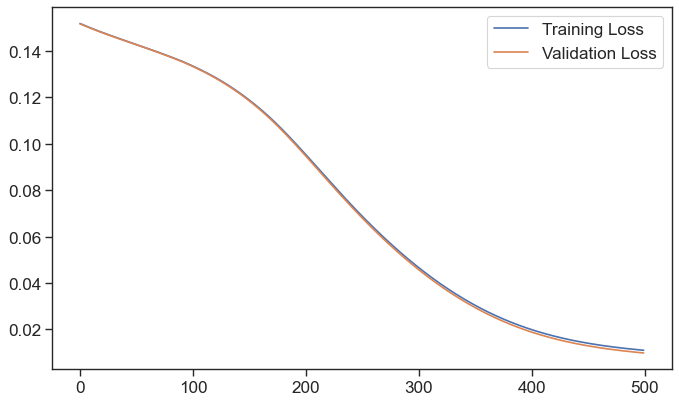

In [302]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

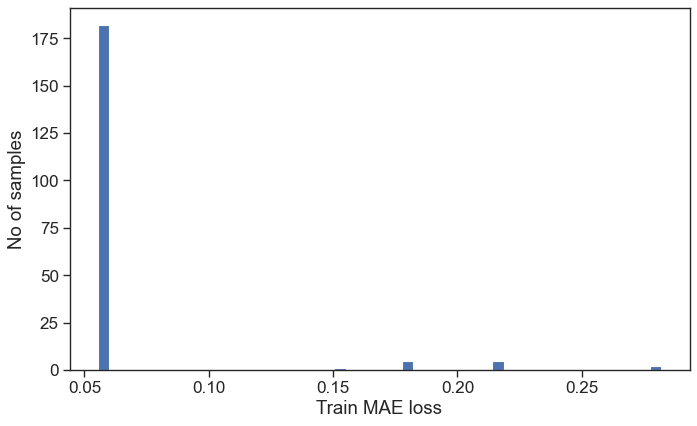

Reconstruction error threshold:  0.05533999800682068


In [303]:
train_pred = model.predict(train_data)
train_mae_loss = np.mean(np.abs(train_pred - train_data), axis=1)

train_mae_loss_df = train_mae_loss.to_frame()
train_mae_loss_df.columns = ['anomaly']
train_mae_loss_counts_df = train_mae_loss_df.groupby(['anomaly']).size().reset_index(name='counts')
threshold = train_mae_loss_counts_df[train_mae_loss_counts_df["counts"] > 10]['anomaly'].max()

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

print("Reconstruction error threshold: ", threshold)

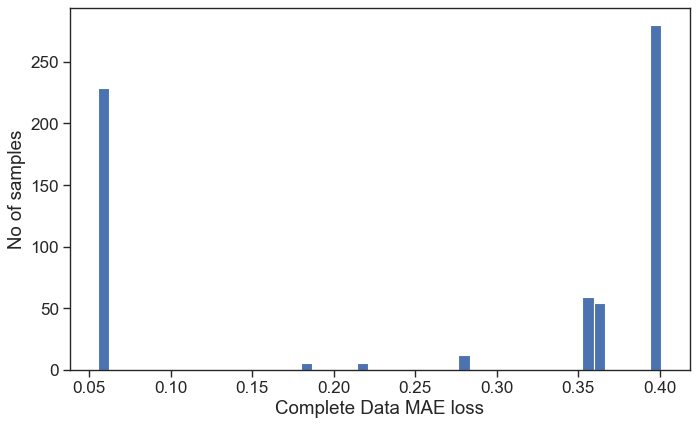

In [304]:
features_pred = model.predict(features)
features_mae_loss = np.mean(np.abs(features_pred - features), axis=1)

plt.figure(figsize=(10, 6), dpi=80)
plt.hist(features_mae_loss, bins=50)
plt.xlabel("Complete Data MAE loss")
plt.ylabel("No of samples")
plt.show()


In [305]:
indexmae = features_mae_loss[features_mae_loss>threshold].index

anomalies = data.loc[indexmae]

anomalies[anomalies['anomaly'] == 0]

,login_success,wrong_password,invalid_user,last_login_success,last_ip_login_failure,user,source_ip,source_port,anomaly
71,0,1,0,0,0,myazure1,182.66.55.189,36534,0
171,1,0,0,0,0,myazure1,223.191.32.164,51625,0
222,0,1,0,1,0,myazure1,223.191.32.164,18245,0
236,1,0,0,0,1,myazure1,223.191.32.164,3150,0
246,0,1,0,1,0,myazure1,223.191.32.164,37394,0
247,1,0,0,0,1,myazure1,223.191.32.164,51287,0
320,0,1,0,1,0,myazure1,223.191.32.164,46984,0
321,1,0,0,0,1,myazure1,223.191.32.164,3145,0
380,0,1,0,1,0,myazure1,223.191.32.164,46988,0
381,1,0,0,0,1,myazure1,223.191.32.164,40086,0


In [306]:
features_loss = features_mae_loss.to_frame()



features_loss.columns = ['anomaly']

features_loss.loc[features_loss.anomaly > threshold, "anomaly"] = 1
features_loss.loc[features_loss.anomaly <= threshold, "anomaly"] = 0

features_loss.shape

(647, 1)

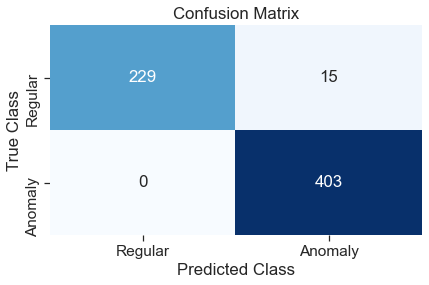

In [307]:
target.columns = ['anomaly']

matrix = confusion_matrix(target, features_loss)
confusion_df = pd.DataFrame(matrix, index = ['Regular', 'Anomaly'], columns = ['Regular', 'Anomaly'])

sns.heatmap(confusion_df, annot=True, fmt="d", cbar=None, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()